先轉換圖片

In [14]:
import os
from PIL import Image

def convert_images_to_jpg(source_folder, target_folder, output_format='jpeg', target_size=(224, 224)):
    # 確保輸出格式是小寫
    output_format = output_format.lower()
    
    # 確保目標資料夾存在
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    
    # 遍歷來源資料夾中的所有文件
    for filename in os.listdir(source_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            source_file_path = os.path.join(source_folder, filename)
            img = Image.open(source_file_path)
            # 調整影像大小
            img = img.resize(target_size, Image.Resampling.LANCZOS)
            # 將檔案名稱提取出來
            base = os.path.splitext(filename)[0]
            # 新檔名
            new_filename = f"{base}.{output_format}"
            target_file_path = os.path.join(target_folder, new_filename)
            
            # 儲存為指定格式到目標資料夾
            img.convert('RGB').save(target_file_path, output_format.upper())
            print(f"Converted {filename} to {new_filename} with size {target_size}")

# 指定來源資料夾和目標資料夾路徑
source_folder = "./face_detect_source" # 替換為你的來源資料夾路徑
target_folder = "./face_detect_done" # 替換為你的目標資料夾路徑

# 轉換所有圖片為 .jpeg 格式，調整解析度並儲存到目標資料夾
convert_images_to_jpg(source_folder, target_folder, output_format='jpeg', target_size=(224, 224))

Converted image_01.jpg to image_01.jpeg with size (224, 224)
Converted image_07.jpg to image_07.jpeg with size (224, 224)
Converted image_06.jpg to image_06.jpeg with size (224, 224)
Converted image_10.jpg to image_10.jpeg with size (224, 224)
Converted image_04.jpg to image_04.jpeg with size (224, 224)
Converted image_05.png to image_05.jpeg with size (224, 224)
Converted image_03.jpeg to image_03.jpeg with size (224, 224)
Converted image_02.jpeg to image_02.jpeg with size (224, 224)
Converted image_08.jpg to image_08.jpeg with size (224, 224)
Converted image_09.png to image_09.jpeg with size (224, 224)


圖片向量儲存

In [8]:
import os
import pandas as pd
import pymongo
import pprint
import certifi
import json
from pymongo import MongoClient
from langchain_openai import ChatOpenAI
import streamlit as st
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import urllib
import ssl

# 設置環境變數
os.environ["OPENAI_API_KEY"] = st.secrets["OPENAI_API_KEY"]
ATLAS_CONNECTION_STRING = st.secrets["MONGODB_URL"]

# 連接到 MongoDB Atlas
client = MongoClient(ATLAS_CONNECTION_STRING, tlsCAFile=certifi.where())
db_name = "ImageDatabase"
collection_name = "ImageEmbeddings"
atlas_collection = client[db_name][collection_name]

# 忽略SSL证书验证
ssl._create_default_https_context = ssl._create_unverified_context

# 初始化模型
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

# 定義圖片嵌入函數
def get_image_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    vgg16_feature = model.predict(img_data)
    return vgg16_feature.flatten()

# 刪除現有數據的函數
def delete_existing_data():
    result = atlas_collection.delete_many({})
    return result.deleted_count

# 初始化數據
def initialize_data(image_folder):
    # 刪除現有數據
    delete_existing_data()

    # 遍歷資料夾中的所有圖片文件
    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(image_folder, filename)
            embedding = get_image_embedding(img_path)
            atlas_collection.insert_one({"image_name": filename, "embedding": embedding.tolist()})
            print(f"Inserted {filename} into the database.")

# 搜索相似圖片
def search_similar_images(query_img_path):
    query_embedding = get_image_embedding(query_img_path)
    
    # 獲取所有已儲存的向量
    stored_images = list(atlas_collection.find({}, {"embedding": 1, "image_name": 1, "_id": 0}))
    embeddings = np.array([img["embedding"] for img in stored_images])
    image_names = [img["image_name"] for img in stored_images]
    
    # 計算餘弦相似度
    similarity_scores = cosine_similarity([query_embedding], embeddings).flatten()
    sorted_indices = similarity_scores.argsort()[::-1]  # 按降序排列
    
    # 獲取前5個相似的圖片
    top_images = [image_names[i] for i in sorted_indices[:5]]
    return top_images

# 設置圖片文件夾路徑
image_folder = "./face_detect_done"

# 檢查集合是否為空，若為空則初始化資料
if atlas_collection.count_documents({}) == 0:
    print("初始化資料並建立向量儲存...")
    initialize_data(image_folder)
else:
    print("載入現有向量儲存...")

# 搜索相似圖片
# 替換為所要查詢圖片路徑
query_img_path = "./face_detect_source/image_01.jpg"
similar_images = search_similar_images(query_img_path)

# 顯示結果
print("相似圖片：")
for img in similar_images:
    print(img)


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 43s 0us/step
初始化資料並建立向量儲存...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Inserted image_09.jpeg into the database.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Inserted image_05.jpeg into the database.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Inserted image_04.jpeg into the database.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Inserted image_08.jpeg into the database.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Inserted image_03.jpeg into the database.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Inserted image_02.jpeg into the database.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Inserted image_01.jpeg into the database.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Inserted image_07.jpeg into the database.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Inserted image_06.jpeg into the database.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Inserted image_10.jpeg into the database.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
相似圖片：
image_01.jpeg
image_07.jpeg
image_09.jpeg
image_06.jpeg
image_08.jpeg


添加評分

In [9]:
import os
import pymongo
import certifi
import json
from pymongo import MongoClient
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import ssl

# 設置環境變數
os.environ["OPENAI_API_KEY"] = st.secrets["OPENAI_API_KEY"]
ATLAS_CONNECTION_STRING = st.secrets["MONGODB_URL"]

# 連接到 MongoDB Atlas
client = MongoClient(ATLAS_CONNECTION_STRING, tlsCAFile=certifi.where())
db_name = "ImageDatabase"
collection_name = "ImageEmbeddings"
atlas_collection = client[db_name][collection_name]

# 忽略SSL证书验证
ssl._create_default_https_context = ssl._create_unverified_context

# 初始化模型
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

# 定義圖片嵌入函數
def get_image_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    vgg16_feature = model.predict(img_data)
    return vgg16_feature.flatten()

# 刪除現有數據的函數
def delete_existing_data():
    result = atlas_collection.delete_many({})
    return result.deleted_count

# 初始化數據
def initialize_data(image_folder):
    # 刪除現有數據
    delete_existing_data()

    # 遍歷資料夾中的所有圖片文件
    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(image_folder, filename)
            embedding = get_image_embedding(img_path)
            atlas_collection.insert_one({"image_name": filename, "embedding": embedding.tolist()})
            print(f"Inserted {filename} into the database.")

# 搜索相似圖片並顯示相似度
def search_similar_images(query_img_path):
    query_embedding = get_image_embedding(query_img_path)
    
    # 獲取所有已儲存的向量
    stored_images = list(atlas_collection.find({}, {"embedding": 1, "image_name": 1, "_id": 0}))
    embeddings = np.array([img["embedding"] for img in stored_images])
    image_names = [img["image_name"] for img in stored_images]
    
    # 計算餘弦相似度
    similarity_scores = cosine_similarity([query_embedding], embeddings).flatten()
    sorted_indices = similarity_scores.argsort()[::-1]  # 按降序排列
    
    # 獲取前5個相似的圖片及其相似度
    top_images = [(image_names[i], similarity_scores[i]) for i in sorted_indices[:5]]
    return top_images

# 設置圖片文件夾路徑
image_folder = "./face_detect_done"

# 檢查集合是否為空，若為空則初始化資料
if atlas_collection.count_documents({}) == 0:
    print("初始化資料並建立向量儲存...")
    initialize_data(image_folder)
else:
    print("載入現有向量儲存...")

# 搜索相似圖片
# 替換為所要查詢圖片路徑
query_img_path = "./face_detect_source/image_01.jpg"
similar_images = search_similar_images(query_img_path)

# 顯示結果
print("相似圖片：")
for img, similarity in similar_images:
    print(f"圖片: {img}, 相似度: {similarity:.4f}")


載入現有向量儲存...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
相似圖片：
圖片: image_01.jpeg, 相似度: 0.9939
圖片: image_07.jpeg, 相似度: 0.5656
圖片: image_09.jpeg, 相似度: 0.4969
圖片: image_06.jpeg, 相似度: 0.4900
圖片: image_08.jpeg, 相似度: 0.4709


顯示圖片

In [11]:
import os
import pymongo
import certifi
import json
from pymongo import MongoClient
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import ssl
import matplotlib.pyplot as plt

# 設置環境變數
os.environ["OPENAI_API_KEY"] = st.secrets["OPENAI_API_KEY"]
ATLAS_CONNECTION_STRING = st.secrets["MONGODB_URL"]

# 連接到 MongoDB Atlas
client = MongoClient(ATLAS_CONNECTION_STRING, tlsCAFile=certifi.where())
db_name = "ImageDatabase"
collection_name = "ImageEmbeddings"
atlas_collection = client[db_name][collection_name]

# 忽略SSL证书验证
ssl._create_default_https_context = ssl._create_unverified_context

# 初始化模型
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

# 定義圖片嵌入函數
def get_image_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    vgg16_feature = model.predict(img_data)
    return vgg16_feature.flatten()

# 刪除現有數據的函數
def delete_existing_data():
    result = atlas_collection.delete_many({})
    return result.deleted_count

# 初始化數據
def initialize_data(image_folder):
    # 刪除現有數據
    delete_existing_data()

    # 遍歷資料夾中的所有圖片文件
    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(image_folder, filename)
            embedding = get_image_embedding(img_path)
            atlas_collection.insert_one({"image_name": filename, "embedding": embedding.tolist()})
            print(f"Inserted {filename} into the database.")

# 搜索相似圖片並顯示相似度
def search_similar_images(query_img_path):
    query_embedding = get_image_embedding(query_img_path)
    
    # 獲取所有已儲存的向量
    stored_images = list(atlas_collection.find({}, {"embedding": 1, "image_name": 1, "_id": 0}))
    embeddings = np.array([img["embedding"] for img in stored_images])
    image_names = [img["image_name"] for img in stored_images]
    
    # 計算餘弦相似度
    similarity_scores = cosine_similarity([query_embedding], embeddings).flatten()
    sorted_indices = similarity_scores.argsort()[::-1]  # 按降序排列
    
    # 獲取前5個相似的圖片及其相似度
    top_images = [(image_names[i], similarity_scores[i]) for i in sorted_indices[:5]]
    return top_images

# 顯示圖片
def display_images(query_img_path, similar_images, image_folder):
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    
    # 顯示查詢圖片
    query_img = image.load_img(query_img_path, target_size=(224, 224))
    axes[0].imshow(query_img)
    axes[0].set_title('Query Image')
    axes[0].axis('off')
    
    # 顯示相似圖片
    for i, (img_name, similarity) in enumerate(similar_images):
        img_path = os.path.join(image_folder, img_name)
        img = image.load_img(img_path, target_size=(224, 224))
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f'{similarity:.4f}')
        axes[i + 1].axis('off')
    
    plt.show()

# 設置圖片文件夾路徑
image_folder = "./face_detect_done"

# 檢查集合是否為空，若為空則初始化資料
if atlas_collection.count_documents({}) == 0:
    print("初始化資料並建立向量儲存...")
    initialize_data(image_folder)
else:
    print("載入現有向量儲存...")

# 搜索相似圖片
# 替換為所要查詢圖片路徑
query_img_path = "./face_detect_source/image_01.jpg"
similar_images = search_similar_images(query_img_path)

# 顯示結果
print("相似圖片：")
for img, similarity in similar_images:
    print(f"圖片: {img}, 相似度: {similarity:.4f}")

# 顯示查詢圖片和相似圖片
display_images(query_img_path, similar_images, image_folder)


載入現有向量儲存...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
相似圖片：
圖片: image_01.jpeg, 相似度: 0.9939
圖片: image_07.jpeg, 相似度: 0.5656
圖片: image_09.jpeg, 相似度: 0.4969
圖片: image_06.jpeg, 相似度: 0.4900
圖片: image_08.jpeg, 相似度: 0.4709


/var/folders/vm/_zft15050r7cfh47y6v5z4k40000gn/T/ipykernel_93126/1560035520.py:95: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


載入現有向量儲存...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
相似圖片：
圖片: image_01.jpeg, 相似度: 0.9939
圖片: image_07.jpeg, 相似度: 0.5656
圖片: image_09.jpeg, 相似度: 0.4969
圖片: image_06.jpeg, 相似度: 0.4900
圖片: image_08.jpeg, 相似度: 0.4709


/var/folders/vm/_zft15050r7cfh47y6v5z4k40000gn/T/ipykernel_93126/3121334875.py:96: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


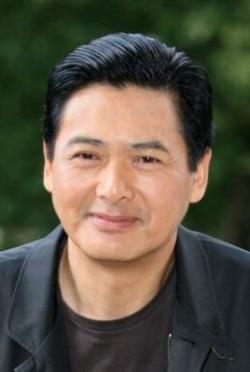

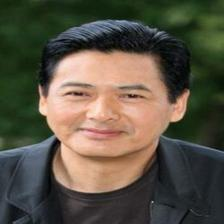

相似度: 0.9939


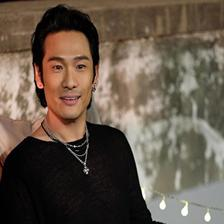

相似度: 0.5656


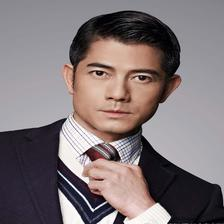

相似度: 0.4969


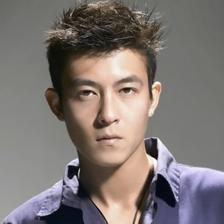

相似度: 0.4900


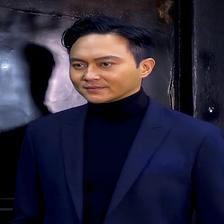

相似度: 0.4709


In [13]:
import os
import pymongo
import certifi
import json
from pymongo import MongoClient
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import ssl
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage

# 設置環境變數
os.environ["OPENAI_API_KEY"] = st.secrets["OPENAI_API_KEY"]
ATLAS_CONNECTION_STRING = st.secrets["MONGODB_URL"]

# 連接到 MongoDB Atlas
client = MongoClient(ATLAS_CONNECTION_STRING, tlsCAFile=certifi.where())
db_name = "ImageDatabase"
collection_name = "ImageEmbeddings"
atlas_collection = client[db_name][collection_name]

# 忽略SSL证书验证
ssl._create_default_https_context = ssl._create_unverified_context

# 初始化模型
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

# 定義圖片嵌入函數
def get_image_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    vgg16_feature = model.predict(img_data)
    return vgg16_feature.flatten()

# 刪除現有數據的函數
def delete_existing_data():
    result = atlas_collection.delete_many({})
    return result.deleted_count

# 初始化數據
def initialize_data(image_folder):
    # 刪除現有數據
    delete_existing_data()

    # 遍歷資料夾中的所有圖片文件
    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(image_folder, filename)
            embedding = get_image_embedding(img_path)
            atlas_collection.insert_one({"image_name": filename, "embedding": embedding.tolist()})
            print(f"Inserted {filename} into the database.")

# 搜索相似圖片並顯示相似度
def search_similar_images(query_img_path):
    query_embedding = get_image_embedding(query_img_path)
    
    # 獲取所有已儲存的向量
    stored_images = list(atlas_collection.find({}, {"embedding": 1, "image_name": 1, "_id": 0}))
    embeddings = np.array([img["embedding"] for img in stored_images])
    image_names = [img["image_name"] for img in stored_images]
    
    # 計算餘弦相似度
    similarity_scores = cosine_similarity([query_embedding], embeddings).flatten()
    sorted_indices = similarity_scores.argsort()[::-1]  # 按降序排列
    
    # 獲取前5個相似的圖片及其相似度
    top_images = [(image_names[i], similarity_scores[i]) for i in sorted_indices[:5]]
    return top_images

# 顯示圖片
def display_images(query_img_path, similar_images, image_folder):
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    
    # 顯示查詢圖片
    query_img = image.load_img(query_img_path, target_size=(224, 224))
    axes[0].imshow(query_img)
    axes[0].set_title('Query Image')
    axes[0].axis('off')
    
    # 顯示相似圖片
    for i, (img_name, similarity) in enumerate(similar_images):
        img_path = os.path.join(image_folder, img_name)
        img = image.load_img(img_path, target_size=(224, 224))
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f'{similarity:.4f}')
        axes[i + 1].axis('off')
    
    plt.show()
    # 在 Jupyter Notebook 中顯示圖片
    display(IPImage(query_img_path))
    for img_name, similarity in similar_images:
        img_path = os.path.join(image_folder, img_name)
        display(IPImage(img_path))
        print(f'相似度: {similarity:.4f}')

# 設置圖片文件夾路徑
image_folder = "./face_detect_done"

# 檢查集合是否為空，若為空則初始化資料
if atlas_collection.count_documents({}) == 0:
    print("初始化資料並建立向量儲存...")
    initialize_data(image_folder)
else:
    print("載入現有向量儲存...")

# 搜索相似圖片
# 替換為所要查詢圖片路徑
query_img_path = "./face_detect_source/image_01.jpg"
similar_images = search_similar_images(query_img_path)

# 顯示結果
print("相似圖片：")
for img, similarity in similar_images:
    print(f"圖片: {img}, 相似度: {similarity:.4f}")

# 顯示查詢圖片和相似圖片
display_images(query_img_path, similar_images, image_folder)
